In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))

import geopandas as gpd
from laos_gggi.plotting import configure_plot_style, prepare_gridspec_figure
from laos_gggi.data_functions.combine_data import load_wb_data, load_co2_data, load_ocean_heat_data, load_gpcc_data, load_all_data
from functools import partial, reduce

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt
from pymc_extras.statespace import BayesianETS
from pymc_extras.statespace.utils.data_tools import ImputationWarning
from functools import partial
import preliz as pz

import warnings
warnings.filterwarnings(action='ignore', 
                        message='Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering',
                        category=ImputationWarning)
warnings.filterwarnings(action='ignore', message='compile_pymc was renamed to compile', category=FutureWarning)
warnings.filterwarnings(action='ignore', message='Skipping `CheckAndRaise` Op (assertion: PyTensor Assert failed!) as JAX tracing would remove it',
                        category=UserWarning)
warnings.filterwarnings(action='ignore', message='The RandomType SharedVariables',
                        category=UserWarning)
configure_plot_style(add_grid=True)

In [3]:
def plot_trajectories(idata, df, forecast = None, group='posterior', 
                      kalman_output = 'smoothed',
                      vars_to_plot=None,
                      hdi_range=(51, 99),
                      n_hdis=40):
    if vars_to_plot is None:
        vars_to_plot = mod.observed_states
        
    fig = plt.figure()
    gs, locs = prepare_gridspec_figure(n_cols=min(len(vars_to_plot), 3), n_plots=len(vars_to_plot), figure=fig)
    
    x_grid = df.index
    h = 30
    plot_data = idata[f'{kalman_output}_{group}_observed']
    
    mu = plot_data.mean(dim=['chain', 'draw'])
    hdi_probs = np.linspace(*hdi_range, n_hdis)
    hdi = {x: az.hdi(plot_data, hdi_prob=x / 100)[f'{kalman_output}_{group}_observed'] for x in hdi_probs}
    
    if forecast:
        x_grid_forecast = forecast['time'].values
        forecast_data = forecast['forecast_observed']
        mu_forecast = forecast_data.mean(dim=['chain', 'draw'])
        hdi_forecast = {x: az.hdi(forecast_data, hdi_prob = x / 100)['forecast_observed'] for x in hdi_probs}

    for loc, name in zip(locs, vars_to_plot):
        axis = fig.add_subplot(gs[loc])
        axis.plot(x_grid, df[name])
        axis.plot(x_grid, mu.sel(observed_state=name))
        
        if forecast:
            axis.plot(x_grid_forecast[:h], mu_forecast.sel(observed_state=name).isel(time=slice(None, h)))

        colors = (hdi_probs - np.min(hdi_probs)) / (np.max(hdi_probs) - np.min(hdi_probs))
        cmap_interp = plt.get_cmap('Oranges')
        cmap_forecast = plt.get_cmap('Greens')

        for i, x in enumerate(hdi_probs[::-1]):
            color_val = colors[i]
            axis.fill_between(x_grid, *hdi[x].sel(observed_state=name).values.T, color=cmap_interp(color_val), alpha=0.6)
            
            if forecast:
                axis.fill_between(x_grid_forecast[:h], *hdi_forecast[x].sel(observed_state=name).isel(time=slice(None, h)).values.T, color=cmap_forecast(color_val), alpha=0.6)

        axis.set_title(name)
    title = f'{kalman_output.title()} {group.title()} (Orange)'
    if forecast:
        title += ' and Forecasts (Green)'
    fig.suptitle(title)
    plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = load_all_data()
df_raw = data['df_time_series']
df_laos = data["df_panel"].loc["ZMB"][["real_gdp", "Population"] ]

df_merged = pd.merge(df_laos, df_raw, left_index=True, right_index= True, how = "right")

#scale values
scaler = StandardScaler()
scaler.set_output(transform='pandas')
df = scaler.fit_transform(df_merged.map(np.log))

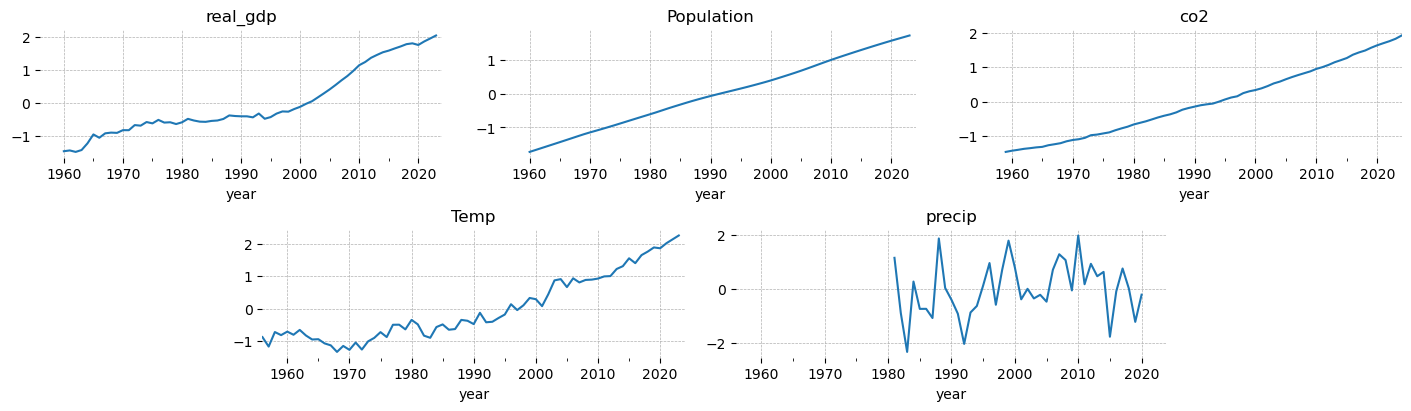

In [5]:
fig = plt.figure()
gs, locs = prepare_gridspec_figure(n_plots=df.shape[1], n_cols=3, figure=fig)
for loc, name in zip(locs, df):
    axis = fig.add_subplot(gs[loc])
    df[name].plot(ax=axis)
    axis.set_title(name)
plt.show()

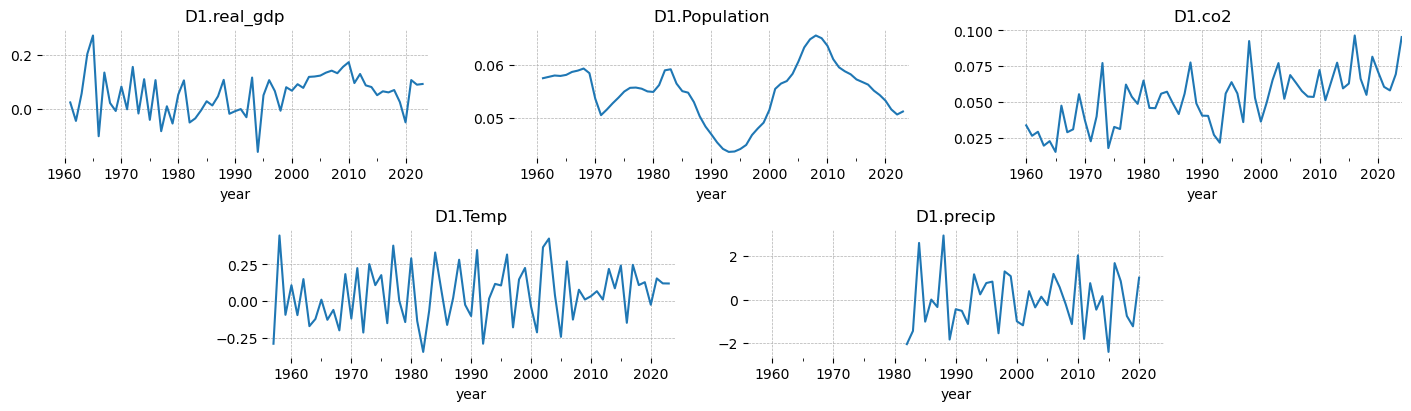

In [6]:
fig = plt.figure()
gs, locs = prepare_gridspec_figure(n_plots=df.shape[1], n_cols=3, figure=fig)
for loc, name in zip(locs, df):
    axis = fig.add_subplot(gs[loc])
    df[name].diff().plot(ax=axis)
    axis.set_title(f'D1.{name}')
plt.show()

In [7]:
mod = BayesianETS(order=('A', 'Ad', 'N'), 
                   endog_names=df.columns, 
                   stationary_initialization=True,
                   dense_innovation_covariance=True,
                   measurement_error=True,
                   initialization_dampening=0.8)

The following parameters should be assigned priors inside a PyMC model block: 
	initial_level -- shape: (5,), constraints: None, dims: ('observed_state',)
	initial_trend -- shape: (5,), constraints: None, dims: ('observed_state',)
	alpha -- shape: (5,), constraints: 0 < alpha < 1, dims: ('observed_state',)
	beta -- shape: (5,), constraints: 0 < beta < 1, dims: ('observed_state',)
	phi -- shape: (5,), constraints: 0 < phi < 1, dims: ('observed_state',)
	state_cov -- shape: (5, 5), constraints: Positive Semi-definite, dims: ('observed_state', 'observed_state_aux')
	sigma_obs -- shape: (5,), constraints: Positive, dims: ('observed_state',)


In [8]:
maxent = partial(pz.maxent, plot=False)

priors = {
    'initial_level': pz.Normal(mu=-2, sigma=1),
    'initial_trend':maxent(pz.Normal(), lower=0.0, upper=0.5),
    'alpha':maxent(pz.Beta(), lower=0.3, upper=0.5),
    'beta':maxent(pz.Beta(), lower=0.1, upper=0.3),
    'phi':maxent(pz.Beta(), lower=0.86, upper=0.99, mass=0.99),
    'sigma_obs': maxent(pz.Gamma(), lower=0.01, upper=0.1, mass=0.7)
}

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\numba\np\ufunc\dufunc.py:287: RuntimeWarning: invalid value encountered in nb_logpdf
  return super().__call__(*args, **kws)


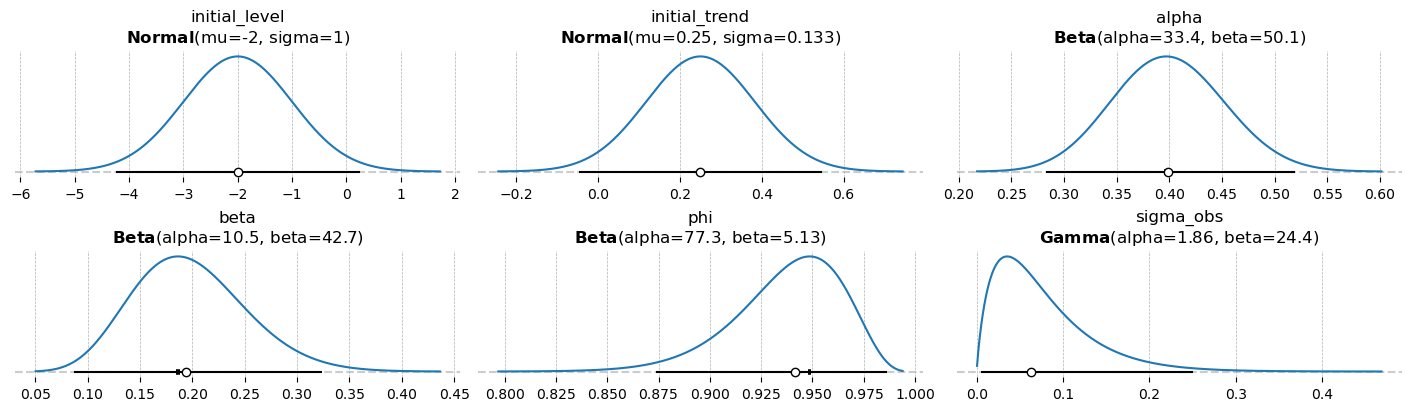

In [9]:
fig = plt.figure(layout='constrained')
gs, locs = prepare_gridspec_figure(n_cols=3, n_plots=len(priors), figure=fig)
for loc, (name, dist) in zip(locs, priors.items()):
    axis = fig.add_subplot(gs[loc])
    dist.plot_pdf(ax=axis, legend='title', pointinterval=True, levels=[0.025, 0.975])
    dist_text = axis.get_title()
    axis.set_title(name + '\n' + dist_text)

In [10]:
import xarray as xr
from itertools import combinations_with_replacement

tril_cov_labels = list(combinations_with_replacement(mod.shock_names, 2))
coords = mod.coords
coords['shock_tril'] = range(len(tril_cov_labels))

shock_tril_idx = xr.Coordinates.from_pandas_multiindex(pd.MultiIndex.from_tuples(tril_cov_labels, names=['shock', 'shock_aux']), 'shock_tril')

In [11]:
sd_dist = maxent(pz.Gamma(), lower=0.01, upper=0.05, mass=0.8).to_pymc()

with pm.Model(coords=coords) as climate_model:
    for name, dist in priors.items():
        dist.to_pymc(name=name, dims=('observed_state', ))
    state_cov_chol, *_ = pm.LKJCholeskyCov('state_cov_chol',
                                           n=mod.k_posdef, 
                                           eta=4,
                                           sd_dist=sd_dist, 
                                           dims=['shock_tril'])
    state_cov = pm.Deterministic('state_cov', state_cov_chol @ state_cov_chol.T, dims=['shock', 'shock_aux'])
    mod.build_statespace_graph(df, mode='JAX')
    
    climate_model.named_vars_to_dims['state_cov_chol_corr'] = ('shock', 'shock_aux')
    climate_model.named_vars_to_dims['state_cov_chol_stds'] = ('shock', )
    
    prior_idata = pm.sample_prior_predictive()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pymc_extras\statespace\utils\data_tools.py:97: UserWarning: No frequency was specific on the data's DateTimeIndex.
  warnings.warn(NO_FREQ_INFO_WARNING)
Sampling: [alpha, beta, initial_level, initial_trend, obs, phi, sigma_obs, state_cov_chol]


In [12]:
prior_traj = mod.sample_conditional_prior(prior_idata)

# HACK -- my shitty statespace code doesn't let you forecast with priors
posterior_data = prior_idata.prior  

# Add the posterior data to the InferenceData object
prior_idata.add_groups(posterior=posterior_data)

prior_forecast = mod.forecast(prior_idata, periods=100)

Sampling: [filtered_prior, filtered_prior_observed, predicted_prior, predicted_prior_observed, smoothed_prior, smoothed_prior_observed]


Output()

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

In [13]:
def inverse(x):
    return np.exp(scaler.inverse_transform(x))

inv_scale_vec = np.vectorize(inverse, signature='(b,k)->(b,k)')


In [14]:
prior_traj_raw = prior_traj.smoothed_prior_observed.copy()
prior_forecast_raw = prior_forecast.forecast_observed.copy()

prior_traj_raw.values[:] = inv_scale_vec(prior_traj_raw.values)
prior_forecast_raw.values[:] = inv_scale_vec(prior_forecast_raw.values)

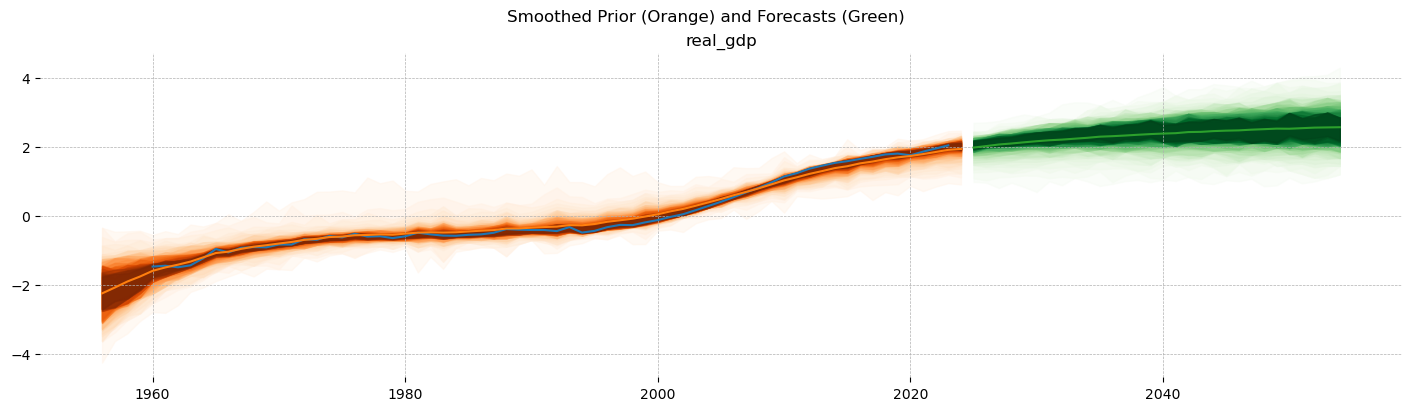

In [15]:
plot_trajectories(prior_traj, 
                  df, 
                  prior_forecast, 
                  group='prior', 
                  kalman_output='smoothed', 
                  vars_to_plot=['real_gdp'])

In [16]:
with climate_model:
    idata = pm.sample(nuts_sampler='nutpie', 
                      nuts_sampler_kwargs={'backend':'jax', 'gradient_backend':'jax'},
                      chains=6,
                      tune=500,
                      draws=1000,
                      target_accept=0.95)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,0,0.19,31
,1500,0,0.20,31
,1500,0,0.19,31
,1500,0,0.18,31
,1500,0,0.18,31
,1500,0,0.17,31


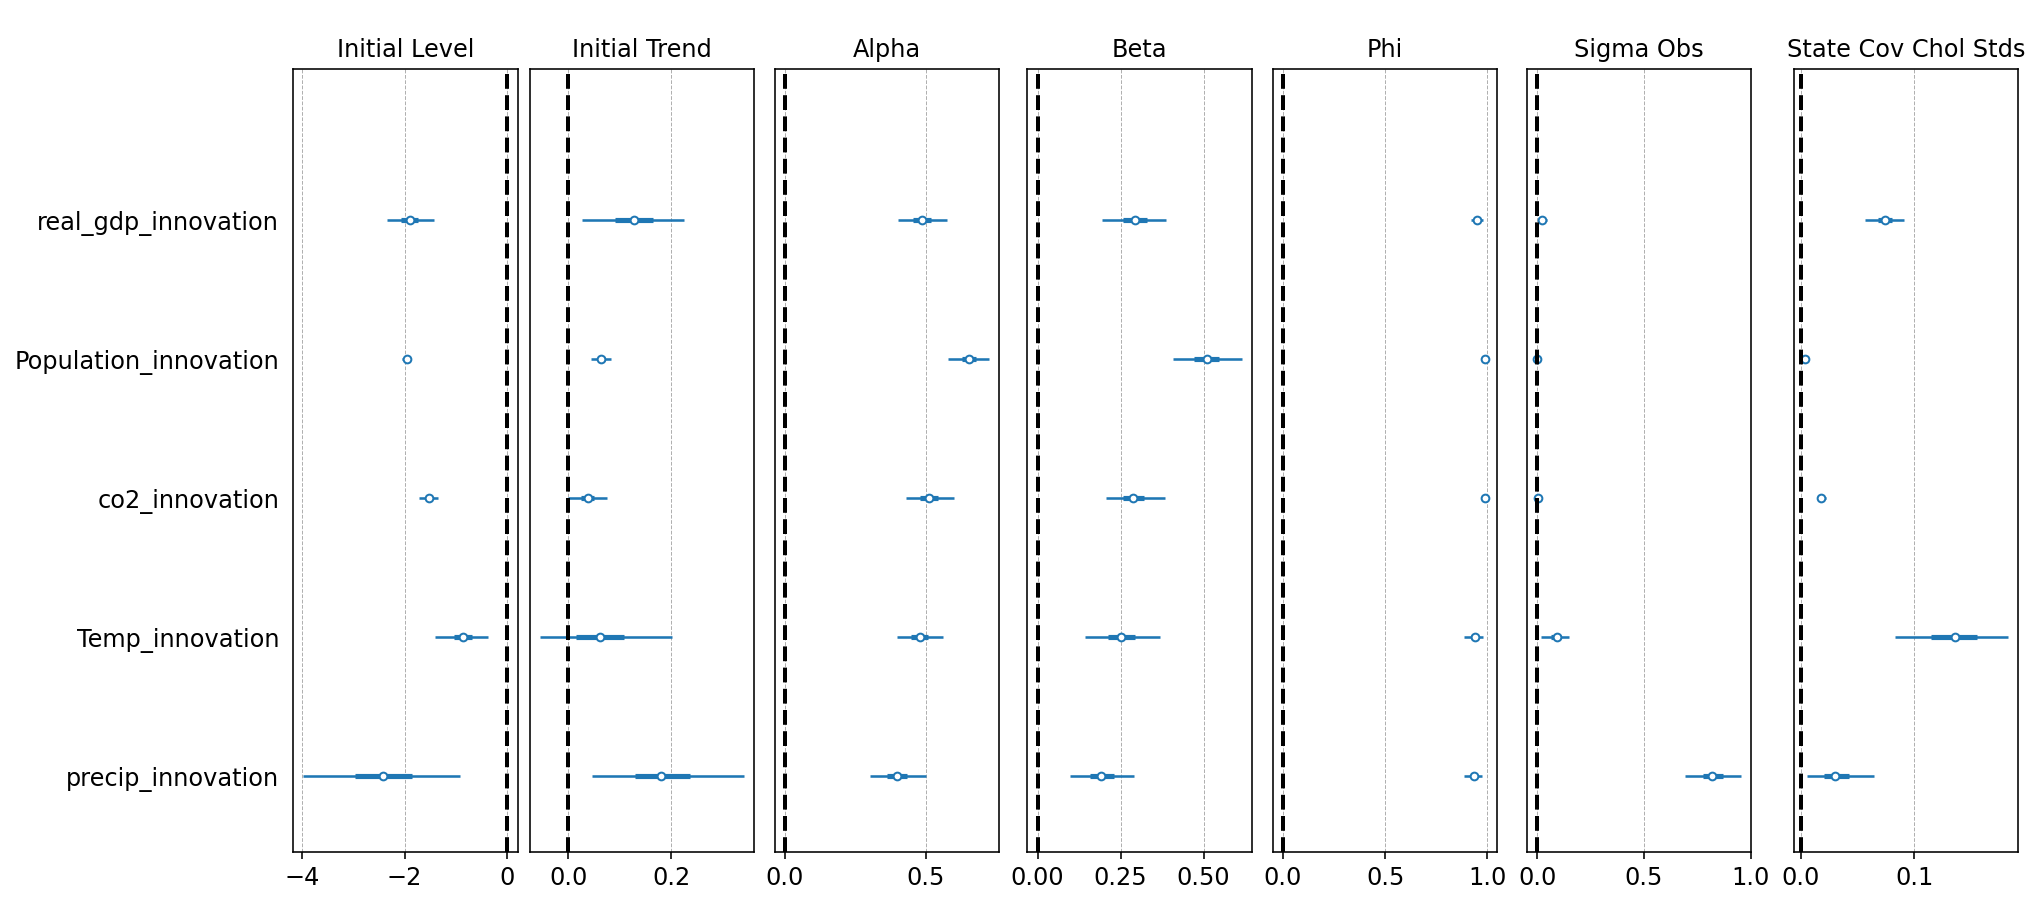

In [17]:
var_names = ['initial_level', 'initial_trend', 'alpha', 'beta', 'phi', 'sigma_obs', 'state_cov_chol_stds']
fig, ax = plt.subplots(1, len(var_names), figsize=(14, 6), dpi=144, layout='constrained', sharey=True)
for axis, name in zip(fig.axes, var_names):
    az.plot_forest(idata, 
                   var_names=[name], 
                   combined=True, 
                   textsize=12,
                   ax=axis,
                  labeller=az.labels.NoVarLabeller())
    axis.axvline(0, ls='--', c='k', lw=2.0)
    axis.set_title(name.replace('_', ' ').title())
    [spine.set_visible(True) for spine in axis.spines.values()]
plt.show()

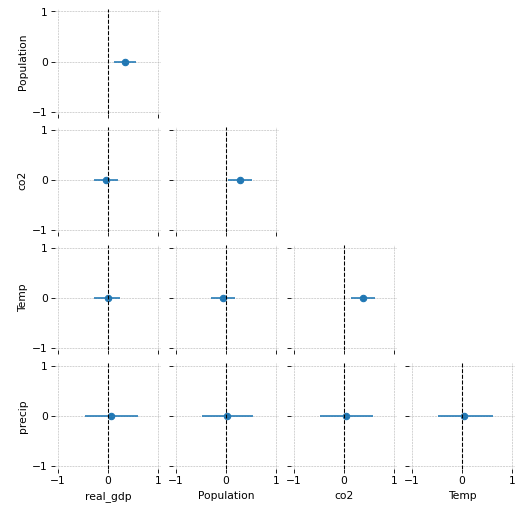

In [18]:
from itertools import product

n_shocks = mod.k_posdef
fig, ax = plt.subplots(n_shocks, n_shocks, 
                       figsize=(8, 8), 
                       dpi=77, 
                       sharex=True, 
                       sharey=True, 
                       subplot_kw={'aspect':'equal'})

for axis, (i,j) in zip(fig.axes, product(range(n_shocks), range(n_shocks))):
    if i <= j:
        axis.set_visible(False)
    if j == 0:
        axis.set_ylabel(mod.observed_states[i])
    if i == (n_shocks - 1):
        axis.set_xlabel(mod.observed_states[j])
    plot_data =idata.posterior.state_cov_chol_corr.isel(shock=i, shock_aux=j)
    hdi = az.hdi(plot_data)['state_cov_chol_corr']
    axis.scatter(plot_data.mean(dim=['chain', 'draw']), 0)
    axis.hlines(0, *hdi.values.T)
    axis.axvline(0, ls='--', lw=1, c='k')
    axis.set(xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))
# fig.suptitle('Posterior Innovation Correlations')
plt.show()

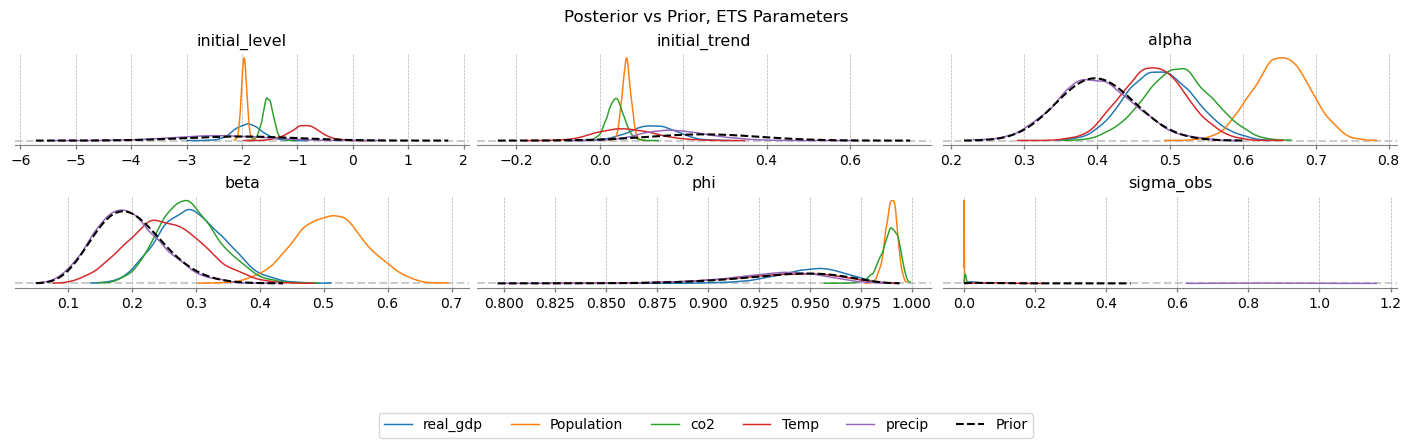

In [19]:
fig = plt.figure(figsize=(14, 4))
gs, locs = prepare_gridspec_figure(n_cols=3, n_plots=len(var_names), figure=fig)

for name, loc in zip(var_names[:-1], locs):
    axis = fig.add_subplot(gs[loc])
    for i, coord in enumerate(
        mod.observed_states):
        color = plt.color_sequences['tab10'][i]
        az.plot_posterior(idata, var_names=[name], ax=axis, point_estimate=None, hdi_prob='hide', coords={'observed_state':coord}, color=color, textsize=10)
    handles = axis.get_lines()
    [handle.set_label(coord) for coord, handle in zip(mod.observed_states, handles)]
    
    priors[name].plot_pdf(ax=axis, legend=False, color='k')
    prior_kde = axis.get_lines()[-1]
    prior_kde.set_linestyle('--')
    prior_kde.set_label('Prior')
    
    handles.append(prior_kde)
    
fig.legend(handles=handles, ncols=mod.k_endog + 1, bbox_to_anchor=(0.5, 0), loc='upper center')
fig.suptitle('Posterior vs Prior, ETS Parameters')
plt.show()

In [20]:
cond_post = mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

In [21]:
forecast = mod.forecast(idata, periods=100)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]


Output()

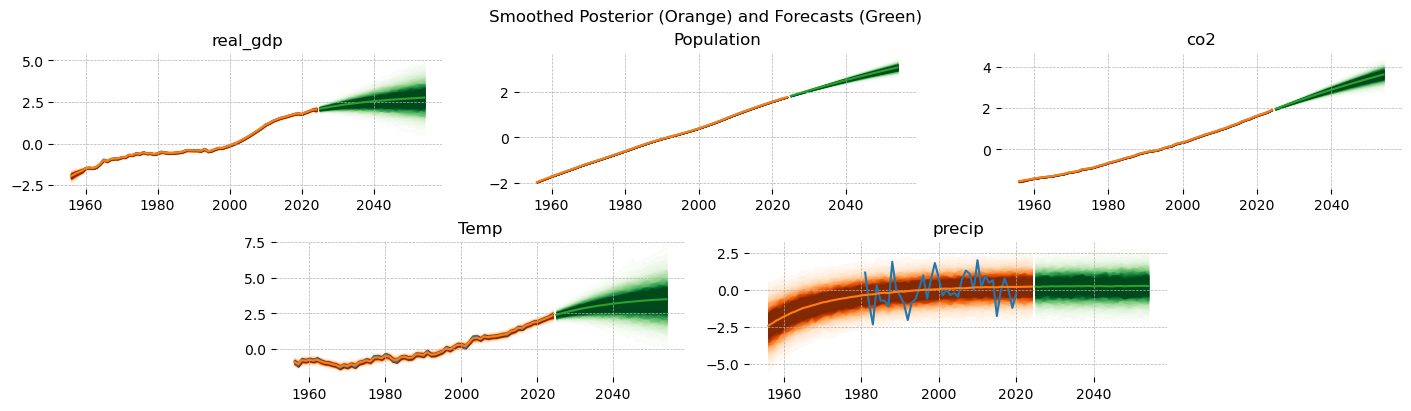

In [22]:
plot_trajectories(cond_post, df, forecast, 
                  group='posterior', 
                  kalman_output='smoothed', 
                  vars_to_plot=None)

In [23]:
cond_post_all_unscaled = xr.concat([cond_post.smoothed_posterior_observed, 
                             forecast.forecast_observed],
                            dim='time')

In [24]:
cond_post_all_unscaled.values[:] = inv_scale_vec(cond_post_all_unscaled.values)

In [25]:
all_dates = pd.to_datetime(cond_post_all_unscaled['time'].values)

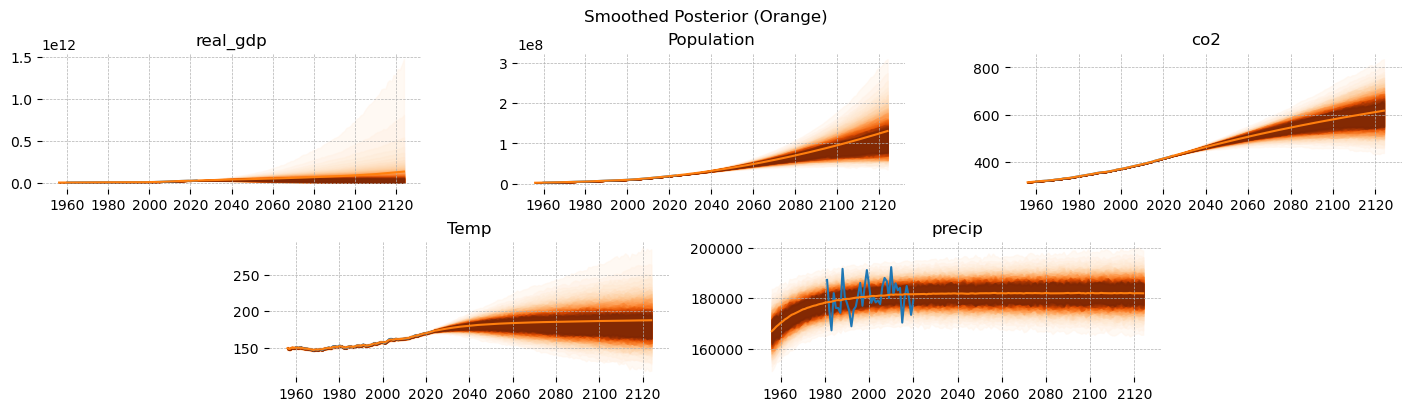

In [26]:
plot_trajectories(cond_post_all_unscaled.to_dataset(), 
                  df_laos.join(df_raw).reindex(all_dates), 
                  None, 
                  group='posterior', 
                  kalman_output='smoothed', 
                  vars_to_plot=None)

In [27]:
gdp_per_cap = cond_post_all_unscaled.sel(observed_state = 'real_gdp') / cond_post_all_unscaled.sel(observed_state='Population')
gdp_per_cap = gdp_per_cap.expand_dims({'observed_state': ['gdp_per_cap']}, create_index_for_new_dim=True)

In [28]:
from statsmodels.tsa.seasonal import STL

def stl_deviation(x):
    trend = STL(x, period=3).fit().trend
    return x - trend

stl_deviation_vec = np.vectorize(stl_deviation, signature=('(b)->(b)'))
coords = {x: cond_post_all_unscaled.coords[x] for x in ['chain', 'draw', 'time']}

temp_deviation = xr.DataArray(stl_deviation_vec(cond_post_all_unscaled.sel(observed_state='Temp'))[..., None],
                              coords= coords | {'observed_state' : ['dev_ocean_temp']},
                              dims=['chain', 'draw', 'time', 'observed_state'],
                              name='dev_ocean_temp')

precip_deviation = xr.DataArray(stl_deviation_vec(cond_post_all_unscaled.sel(observed_state='precip'))[..., None],
                              coords=coords | {'observed_state' : ['precip_deviation']},
                              dims=['chain', 'draw', 'time', 'observed_state'],
                              name='precip_deviation')


In [29]:
cond_post_all_unscaled = xr.concat([cond_post_all_unscaled, gdp_per_cap, temp_deviation, precip_deviation],
          dim='observed_state')

In [30]:
def to_dataframe(post):
    return (post.quantile(0.55, dim=['chain', 'draw'])
     .to_dataframe()
     .drop(columns=['quantile'])
     .unstack('observed_state')
     .droplevel(axis=1, level=0))

In [31]:
res_df = to_dataframe(cond_post_all_unscaled)

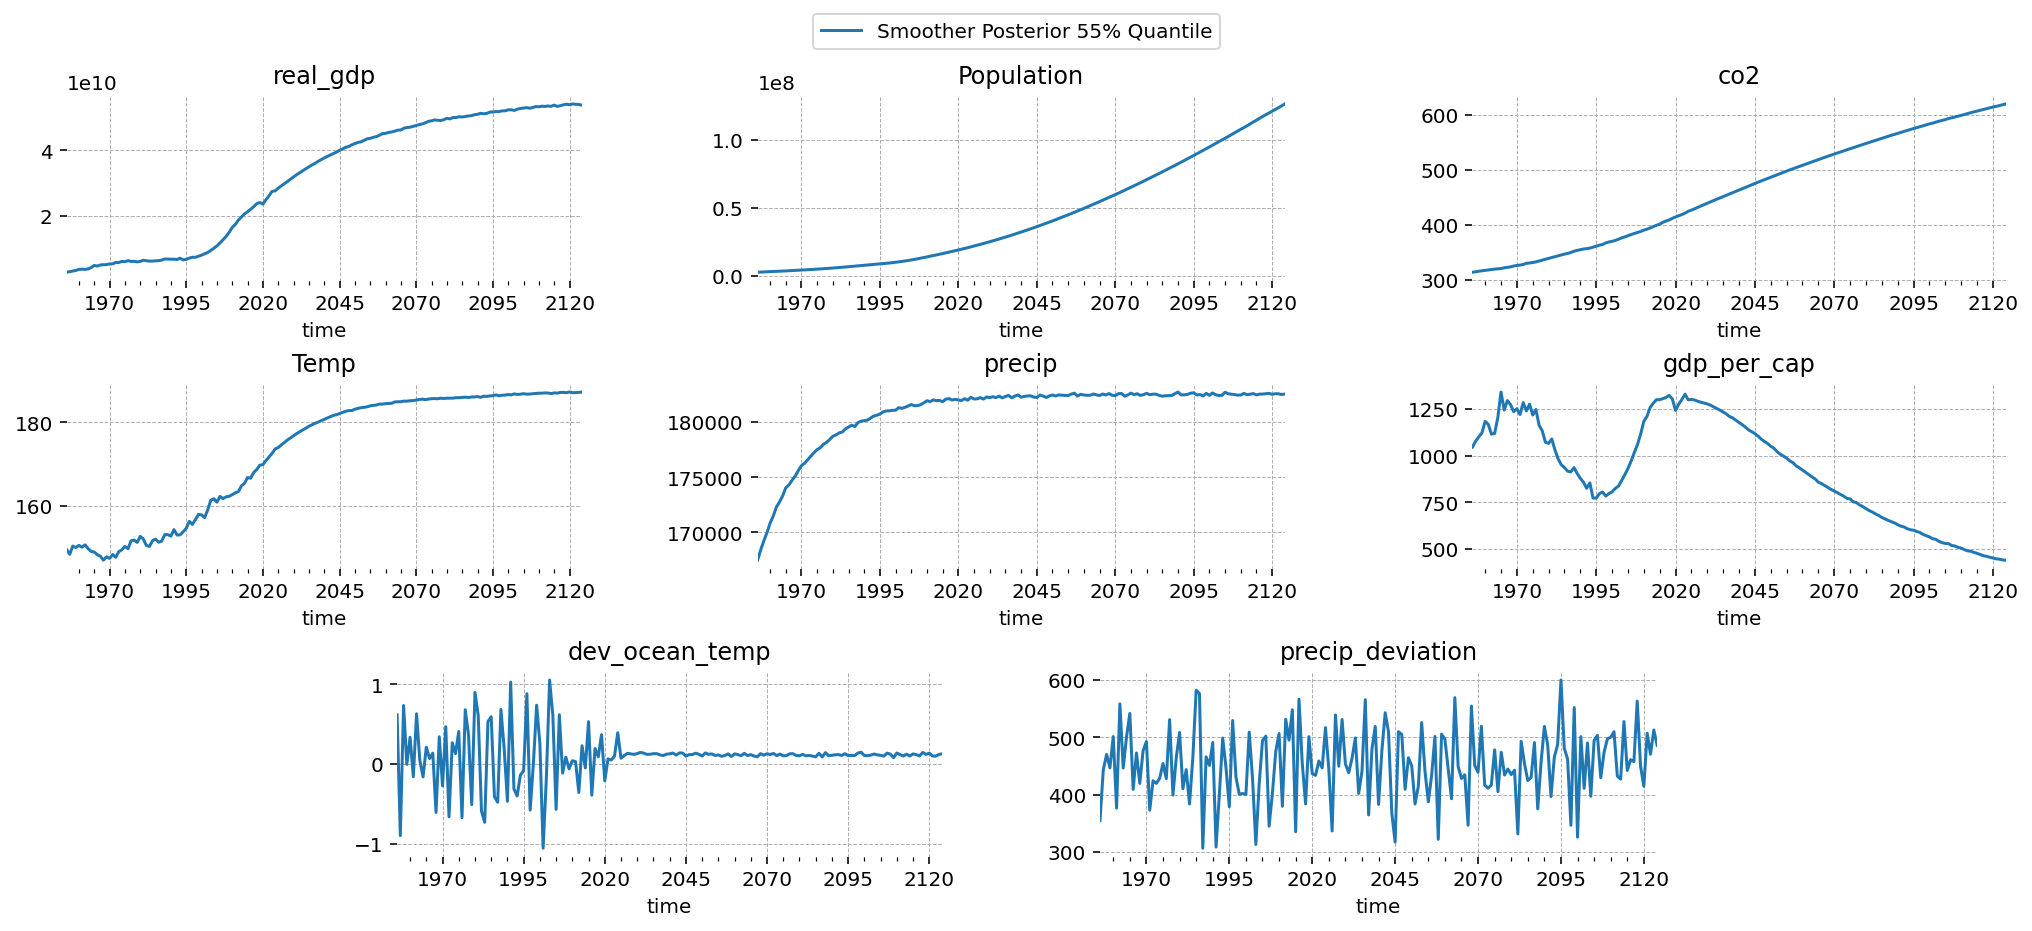

In [32]:
fig = plt.figure(figsize=(14, 6), dpi=144)
gs, locs = prepare_gridspec_figure(n_cols=3, n_plots=res_df.shape[1], figure=fig)

for loc, name in zip(locs, res_df.columns):
    axis = fig.add_subplot(gs[loc])
    
    res_df[name].plot(ax=axis, label='Smoother Posterior 55% Quantile')
#     df_merged[name].plot(ax=axis, label='Original Data')
    handles = axis.get_lines()
    axis.set_title(name)
fig.legend(handles=handles, ncol=3, bbox_to_anchor=(0.5, 1.0), loc='lower center')
plt.show()

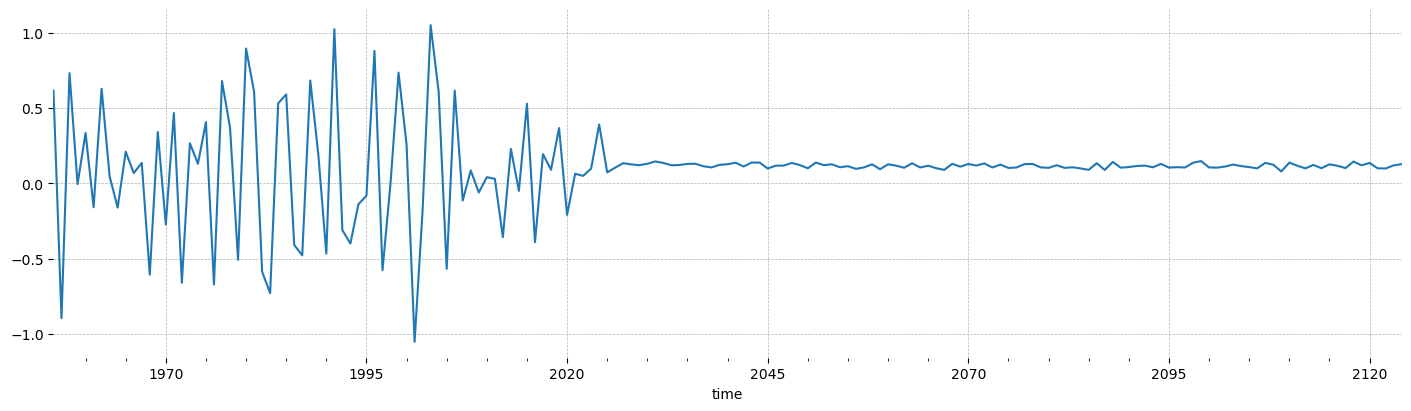

In [33]:
res_df["dev_ocean_temp"].plot();

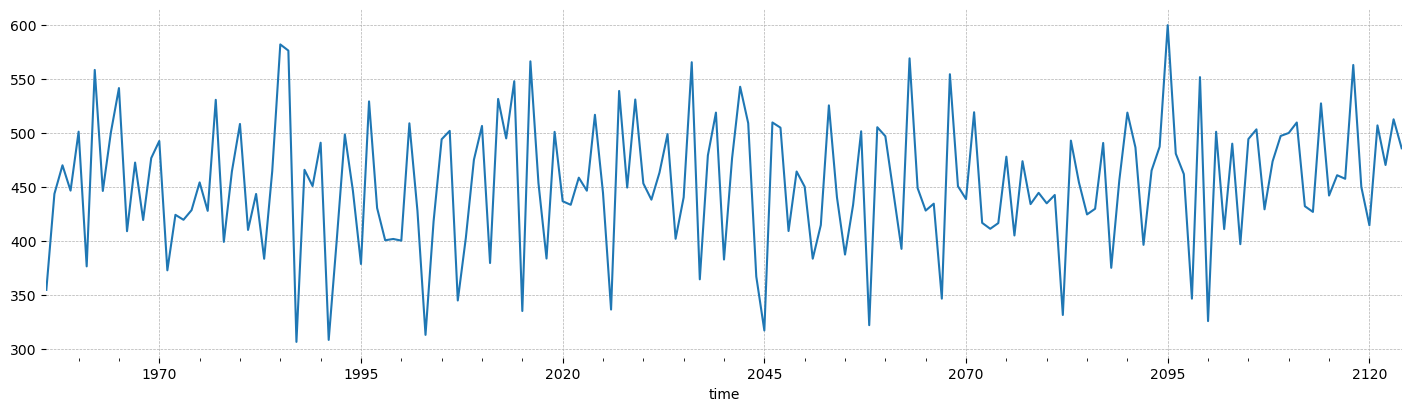

In [34]:
res_df["precip_deviation"].plot();

In [40]:
# Calculate variables
res_df["log_population_density"] = np.log(res_df["Population"] / 752618)
res_df["log_population_density_squared"] = res_df["log_population_density"]  ** 2
res_df["log_gdp_per_cap"] = np.log(res_df["gdp_per_cap"])
res_df["log_gdp_per_cap_squared"] = res_df["log_gdp_per_cap"]  ** 2


In [41]:
res_df.to_csv(here('data/zmb_forecast.csv'))